# Calgary's Single Family Permits - Exploratory Data Analysis and Cost Prediction Modeling

Calgary is a beautiful city located in the Canadian province of Alberta. Situated at the footsteps of the Rocky Mountains, its metropolitan area is home to over 1.6 million people and growing steadily.

I had the opportunity to live in Calgary for about two years where I worked for a local land developer. I think the city has a lot to offer but often gets overlooked in favour of other larger Canadian cities. As such, I felt compelled to make this notebook and take a dive into Calgary's single family real estate market.

The dataset that I am using comes from the City of Calgary Open Data Portal. The file that I am using is the Building Permits dataset that contains information on every single building permit that has ever been filed in the City of Calgary as of 1996. Each row in the dataset represents a building permit with a unique identifier. Below is a link to the dataset:

https://data.calgary.ca/Business-and-Economic-Activity/Building-Permits/c2es-76ed

This notebook will consist of three parts. The first part will be dedicated to data cleaning, wrangling, handling missing values, and removing outliers. The second part will be dedicated to exploring the data, uncovering and analyzing trends, and gaining insights into the single family market. In the third part I will build a cost prediction model to predict the project cost of a particular single family house.

Before I begin, I should note a few things:

- The project cost of a permit does not equal the overall cost of a home. We can think of project cost as the construction cost of a house, not the sale price. 


- I am only interested in looking at permits that were applied for as of January 2010.


- I am only going to look at applications that are deemed complete, meaning that the home was actually built.


- Since there are a lot of contractors and builders that operate in Calgary, I am only going to look at the top 10 builders by value count. This will still provide a good overview of the trends in Calgary's single family real estate market as the top 10 builders make up the vast majority of the permit applications. This will also reduce the number of dimensions and the likelihood of overfitting the prediction model.

## The Data

The dataset I am working with refreshes daily. I would like to capitalize on this and feed the prediction model new data as it becomes available. While the city does provide access to the dataset via an API, I ran into computational issues trying to pull such a large amount of data with this method. Fortunately, the city also provides a link to the dataset via an OData endpoint. Using Power Query, I have setup a link to the dataset and saved an excel copy of the file on my local machine. This way I am able to refresh the dataset through Excel and pull in the new data as it gets upload into the city database. I know this is not the most efficient approach to getting the data, but it is a reasonable work around for my purposes.

Rather than using Power Query to do all of the data cleaning I have opted to do these steps using Python.

In [1]:
#Import packages and set options/styles.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import calendar
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('use_inf_as_na', True)
sns.set_style('whitegrid')

#Set the font style for all visualizations

font = {'family':'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)


In [2]:
#Create the dataframe

df = pd.read_csv('CalgaryPermits.csv')
df.head()

,__id,permitnum,statuscurrent,applieddate,issueddate,completeddate,permittype,permittypemapped,permitclass,permitclassgroup,permitclassmapped,workclass,workclassgroup,workclassmapped,description,contractorname,housingunits,estprojectcost,totalsqft,originaladdress,communitycode,communityname,latitude,longitude,location,location_address,location_city,location_state,location_zip,locationcount,locationtypes,locationaddresses,locationswkt,locationsgeojson,:@computed_region_4b54_tmc4,:@computed_region_4a3i_ccfj,:@computed_region_kxmf_bzkv,:@computed_region_p8tp_5dkv
0,row-kd8q.ydnw_q6eq,BP2017-01497,Completed,2017-02-20 0:00,2017-08-11 0:00,2018-10-10 0:00,Single Construction Permit,Building,1106 - Single Family House,Single Family,Residential,New,New,New,"SFD,BSMT-DEV,FIREPLACE,DECK,PORCH,",BURNTWOOD HOLDINGS,1,"516,526.87000","3,468.00000",24 LORNE PL SW,NGM,NORTH GLENMORE PARK,50.99652,-114.11437,POINT (-114.114373427154 50.9965229583869),NaN,NaN,NaN,NaN,2.00000,Titled Parcel;Building,24 LORNE PL SW;24 LORNE PL SW,MULTIPOINT (-114.114373427154 50.9965229583869...,"{""type"":""MultiPoint"",""coordinates"":[[-114.1143...",NaN,NaN,NaN,NaN
1,row-9jwr~7fe7_ju22,BP2017-02879,Completed,2017-03-27 0:00,2017-04-06 0:00,2018-10-10 0:00,Commercial / Multi Family Project,Building,3204 - Warehouse/Office,Commercial,Non-Residential,Alteration,Improvement,Existing,Interior Alteration - Signature Truck Lines,NaN,0,"136,000.00000",NaN,4840 90 AV SE,SFH,SOUTH FOOTHILLS,50.97245,-113.96568,POINT (-113.965683779246 50.972454482996),NaN,NaN,NaN,NaN,2.00000,Titled Parcel;Building,4840 90 AV SE;4840 90 AV SE,"MULTIPOINT (-113.965683779246 50.972454482996,...","{""type"":""MultiPoint"",""coordinates"":[[-113.9656...",NaN,NaN,NaN,NaN
2,row-g4h4-qzyz.mwnj,BP2017-04553,Completed,2017-04-28 0:00,2017-06-13 0:00,2018-10-10 0:00,Commercial / Multi Family Project,Building,2309 - Terminal-Bus,Industrial,Non-Residential,New,New,New,Group A2 Passenger Station,NaN,0,"110,000.00000",NaN,851B HERITAGE DR SW,UND,Undefined,50.97944,-114.08255,POINT (-114.082548572958 50.9794446354508),NaN,NaN,NaN,NaN,1.00000,Structure,851B HERITAGE DR SW,POINT (-114.082548572958 50.9794446354508),"{""type"":""Point"",""coordinates"":[-114.0825485729...",NaN,NaN,NaN,NaN
3,row-g5zi_gw3j~2tdn,BP2017-06611,Completed,2017-06-05 0:00,2017-06-20 0:00,2018-10-10 0:00,Commercial / Multi Family Project,Building,3402 - Office,Commercial,Non-Residential,Alteration,Improvement,Existing,TRANSCANADA Fire Alarm Upgrade,NaN,0,"1,427,000.00000",NaN,450 1 ST SW,DNC,DOWNTOWN COMMERCIAL CORE,51.04858,-114.06464,POINT (-114.064641415824 51.0485761459347),NaN,NaN,NaN,NaN,3.00000,Titled Parcel;Titled Parcel;Building,120 5 AV SW;125 4 AV SW;450 1 ST SW,MULTIPOINT (-114.064641415824 51.0485761459347...,"{""type"":""MultiPoint"",""coordinates"":[[-114.0646...",NaN,NaN,NaN,NaN
4,row-24ix~np24~3ypa,BP2017-09314,Completed,2017-07-21 0:00,2017-10-04 0:00,2018-10-10 0:00,Commercial / Multi Family Project,Building,3503 - Auditorium,Commercial,Non-Residential,New,New,New,New Walton Hall building with Calgary Stampede...,NaN,0,"2,297,000.00000",NaN,623 13 AV SE,BLN,BELTLINE,51.03998,-114.04992,POINT (-114.049917512905 51.0399802126248),NaN,NaN,NaN,NaN,2.00000,Titled Parcel;Building,619 13 AV SE;623 13 AV SE,MULTIPOINT (-114.049917512905 51.0399802126248...,"{""type"":""MultiPoint"",""coordinates"":[[-114.0499...",NaN,NaN,NaN,NaN


In [3]:
#Check the data types and for null values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380790 entries, 0 to 380789
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   __id                         380790 non-null  object 
 1   permitnum                    380790 non-null  object 
 2   statuscurrent                380790 non-null  object 
 3   applieddate                  380790 non-null  object 
 4   issueddate                   371193 non-null  object 
 5   completeddate                364745 non-null  object 
 6   permittype                   380790 non-null  object 
 7   permittypemapped             380790 non-null  object 
 8   permitclass                  380744 non-null  object 
 9   permitclassgroup             380790 non-null  object 
 10  permitclassmapped            380790 non-null  object 
 11  workclass                    380790 non-null  object 
 12  workclassgroup               380790 non-null  object 
 13 

In [4]:
#Check the unique values within the permitclass column

df['permitclass'].unique()

array(['1106 - Single Family House', '3204 - Warehouse/Office',
       '2309 - Terminal-Bus', '3402 - Office', '3503 - Auditorium',
       '1101 - Basement Development', '3299 - Storage/Warehouse Misc.',
       '1301 - Private Detached Garage',
       '1407 - Two Family Semi-Detached (1 Unit)', '1106 - House',
       '1116 - Repair After Fire', '1506 - Apt Apartment',
       '1106 - Addition', '3510 - Recreation Facility',
       '3106 - Retail Shop', '1601 - Basement Development',
       '3613 - Restaurant - Licensed', '5401 - Church',
       '1101 - Improvements (Single Family)',
       '1401 - Basement Development', '2125 - Food Products',
       '4002 - Vacant', '5103 - University, Mt Royal', '1102 - Carport',
       '9999 - Unspecified', '3605 - Food Kiosk', '5299 - Medical Misc.',
       '3714 - Dry Cleaning On Site', '3203 - Warehouse',
       '2306 - Parking Garage', '3507 - Community Centre',
       '2105 - Brewery/Distillery', '1508 - Apt Fourplex',
       '1114 - Detached Ga

Already I can see that the dataframe is quite large and contains a lot of information that is not useful for the purpose of this notebook. For example, the cell above shows that the dataframe contains a multitude of different types of permits. Since I am only interested in single family permits, I will have to filter the dataframe down.

## Data Filtering and Cleaning

In terms of filtering and cleaning, I am going to do the following:

- Cast the date columns into datetime.


- Filter the dataframe down so it only shows permits that were applied for on or after January 1st 2010.


- Filter the dataframe so it only shows permits that are completed.


- Filter the dataframe down to the top 10 builders by value count.


- Drop unnecessary columns.

In [5]:
#Convert date columns into datetime

df['applieddate'] = pd.to_datetime(df['applieddate'])
df['issueddate'] = pd.to_datetime(df['issueddate'])
df['completeddate'] = pd.to_datetime(df['completeddate'], errors='coerce')

print(df['applieddate'].dtypes)
print(df['issueddate'].dtypes)
print(df['completeddate'].dtypes)

datetime64[ns]
datetime64[ns]
datetime64[ns]


In [6]:
#Filter the dataframe down to values after January 1, 2010

df = df[df['applieddate'] >= '2010-01-01']
df['applieddate'].min()

Timestamp('2010-01-04 00:00:00')

In [7]:
#Filter the dataframe down to only show single family permits and construction permits

df = df[df['permitclass'] == '1106 - Single Family House']
df = df[df['permittype'] == 'Single Construction Permit']

In [8]:
#Check the permit status

df['statuscurrent'].unique()

array(['Completed', 'Cancelled', 'Final Phase', 'Pre Backfill Phase',
       'File Closed', 'Pre Board Phase', 'Hold', 'Expired', 'Refused',
       'In Review', 'New', 'Pending - Building By-Law Review'],
      dtype=object)

In [9]:
#Filter the dataframe so it only shows permits that have been completed i.e the house has been built

df = df[df['statuscurrent'] == 'Completed']
df.tail()

,__id,permitnum,statuscurrent,applieddate,issueddate,completeddate,permittype,permittypemapped,permitclass,permitclassgroup,permitclassmapped,workclass,workclassgroup,workclassmapped,description,contractorname,housingunits,estprojectcost,totalsqft,originaladdress,communitycode,communityname,latitude,longitude,location,location_address,location_city,location_state,location_zip,locationcount,locationtypes,locationaddresses,locationswkt,locationsgeojson,:@computed_region_4b54_tmc4,:@computed_region_4a3i_ccfj,:@computed_region_kxmf_bzkv,:@computed_region_p8tp_5dkv
371380,row-gk8i~ayvv~y3c8,BP2021-04109,Completed,2021-03-18,2021-04-07,2021-06-21,Single Construction Permit,Building,1106 - Single Family House,Single Family,Residential,New,New,New,"SFD,GARAGE,DECK,PORCH,",KLAIR CUSTOM HOMES,1,"381,365.40000","2,380.00000",20 SADDLECREST LI NE,SAD,SADDLE RIDGE,51.13436,-113.93579,POINT (-113.93579043204481 51.134364754898854),NaN,NaN,NaN,NaN,2.00000,Titled Parcel;Building,20 SADDLECREST LI NE;20 SADDLECREST LI NE,MULTIPOINT (-113.93579043204481 51.13436475489...,"{""type"":""MultiPoint"",""coordinates"":[[-113.9357...",NaN,NaN,NaN,NaN
371419,row-xyrp.5gyj-ggab,BP2021-04148,Completed,2021-03-18,2021-04-26,2021-06-14,Single Construction Permit,Building,1106 - Single Family House,Single Family,Residential,New,New,New,"SFD,GARAGE,DECK,PORCH,",KLAIR CUSTOM HOMES,1,"372,622.98000","2,330.00000",136 SADDLECREST CI NE,SAD,SADDLE RIDGE,51.13433,-113.93816,POINT (-113.93816288836062 51.13433456970791),NaN,NaN,NaN,NaN,2.00000,Titled Parcel;Building,136 SADDLECREST CI NE;136 SADDLECREST CI NE,MULTIPOINT (-113.93816288836062 51.13433456970...,"{""type"":""MultiPoint"",""coordinates"":[[-113.9381...",NaN,NaN,NaN,NaN
371603,row-38gf-aquj-aeck,BP2021-04332,Completed,2021-03-22,2021-04-08,2021-07-27,Single Construction Permit,Building,1106 - Single Family House,Single Family,Residential,New,New,New,"SFD,FIREPLACE,GARAGE,DECK,PORCH,",KLAIR CUSTOM HOMES,1,"421,769.31000","2,635.00000",355 SADDLECREST CI NE,SAD,SADDLE RIDGE,51.13502,-113.93916,POINT (-113.9391576780509 51.13501830065101),NaN,NaN,NaN,NaN,2.00000,Titled Parcel;Building,355 SADDLECREST CI NE;355 SADDLECREST CI NE,MULTIPOINT (-113.9391576780509 51.135018300651...,"{""type"":""MultiPoint"",""coordinates"":[[-113.9391...",NaN,NaN,NaN,NaN
371741,row-vrxg-i9m6-dmyy,BP2021-04471,Completed,2021-03-23,2021-04-20,2021-07-12,Single Construction Permit,Building,1106 - Single Family House,Single Family,Residential,New,New,New,"SFD,FIREPLACE,GARAGE,DECK,PORCH,",KLAIR CUSTOM HOMES,1,"374,407.13000","2,300.00000",128 SADDLECREST CI NE,SAD,SADDLE RIDGE,51.13433,-113.93784,POINT (-113.93784263264227 51.13433439994834),NaN,NaN,NaN,NaN,2.00000,Titled Parcel;Building,128 SADDLECREST CI NE;128 SADDLECREST CI NE,MULTIPOINT (-113.93784263264227 51.13433439994...,"{""type"":""MultiPoint"",""coordinates"":[[-113.9378...",NaN,NaN,NaN,NaN
372796,row-dcsb-hs67-ridd,BP2021-05526,Completed,2021-04-07,2021-04-19,2021-07-28,Single Construction Permit,Building,1106 - Single Family House,Single Family,Residential,New,New,New,"SFD,GARAGE,DECK,PORCH,",KLAIR CUSTOM HOMES,1,"389,917.56000","2,432.00000",80 SADDLECREST LI NE,SAD,SADDLE RIDGE,51.13522,-113.93671,POINT (-113.93671372607038 51.1352192696534),NaN,NaN,NaN,NaN,2.00000,Titled Parcel;Building,80 SADDLECREST LI NE;80 SADDLECREST LI NE,MULTIPOINT (-113.93671372607038 51.13521926965...,"{""type"":""MultiPoint"",""coordinates"":[[-113.9367...",NaN,NaN,NaN,NaN


In [10]:
#Filter the dataframe down to the top 10 builders by value count

top_10_builders = df['contractorname'].value_counts().nlargest(10).index.tolist()
df = df[df.contractorname.isin(top_10_builders)]

At this point I have the top 10 builders of single family homes as of January 1, 2010. The next thing I will do is drop all of the unnecessary columns, rename the remaining columns, and rename some of the row values.

In [11]:
df.columns

Index(['__id', 'permitnum', 'statuscurrent', 'applieddate', 'issueddate',
       'completeddate', 'permittype', 'permittypemapped', 'permitclass',
       'permitclassgroup', 'permitclassmapped', 'workclass', 'workclassgroup',
       'workclassmapped', 'description', 'contractorname', 'housingunits',
       'estprojectcost', 'totalsqft', 'originaladdress', 'communitycode',
       'communityname', 'latitude', 'longitude', 'location',
       'location_address', 'location_city', 'location_state', 'location_zip',
       'locationcount', 'locationtypes', 'locationaddresses', 'locationswkt',
       'locationsgeojson', ':@computed_region_4b54_tmc4',
       ':@computed_region_4a3i_ccfj', ':@computed_region_kxmf_bzkv',
       ':@computed_region_p8tp_5dkv'],
      dtype='object')

In [12]:
columns_to_drop = ['__id','permitnum', 'statuscurrent', 'permittype', 'permittypemapped', 'permitclass',
       'permitclassgroup', 'permitclassmapped', 'workclass', 'workclassgroup',
       'workclassmapped', 'description', 'communitycode', 'location',
       'location_address', 'location_city', 'location_state', 'location_zip',
       'locationcount', 'locationtypes', 'locationaddresses', 'locationswkt',
       'locationsgeojson', ':@computed_region_4b54_tmc4',
       ':@computed_region_4a3i_ccfj', ':@computed_region_kxmf_bzkv',
       ':@computed_region_p8tp_5dkv']

df.drop(columns=columns_to_drop, inplace = True)

In [13]:
#Have a look at the dataframe after dropping columns

df.head()

,applieddate,issueddate,completeddate,contractorname,housingunits,estprojectcost,totalsqft,originaladdress,communityname,latitude,longitude
17,2019-01-31,2019-02-08,2019-07-17,TRICO HOMES,1,"404,123.15000","2,501.00000",995 CARRINGTON BV NW,CARRINGTON,51.17866,-114.08431
27,2018-02-23,2018-02-27,2018-10-10,MORRISON HOMES (CALGARY),1,"519,244.25000","2,999.00000",220 LEGACY MT SE,LEGACY,50.85353,-114.01558
31,2018-03-23,2018-03-29,2018-10-10,BROOKFIELD RESIDENTIAL (ALBERTA),1,"269,800.59000","1,781.00000",88 SETON TC SE,SETON,50.86927,-113.95864
45,2018-05-03,2018-05-10,2018-10-10,MORRISON HOMES (CALGARY),1,"248,422.27000","1,525.00000",11 BELMONT GD SE,BELMONT,50.86616,-114.06158
48,2018-05-10,2018-05-16,2018-10-10,JAYMAN MASTERBUILT / WENDI INTERIORS,1,"241,374.10000","1,522.00000",544 BELMONT HE SE,BELMONT,50.86616,-114.06615


In [14]:
#Rename the columns

new_columns = {'applieddate':'AppliedDate',
               'issueddate':'IssuedDate',
              'completeddate':'CompletedDate',
              'contractorname':'Builder',
               'housingunits':'Units',
              'estprojectcost':'ProjectCost',
              'totalsqft':'Sqft',
              'originaladdress':'Address',
              'communityname':'Community',
              'latitude':'Latitude',
              'longitude':'Longitude',
              }

df.rename(columns = new_columns, inplace = True)

In [15]:
#View the dataframe

df.head()

,AppliedDate,IssuedDate,CompletedDate,Builder,Units,ProjectCost,Sqft,Address,Community,Latitude,Longitude
17,2019-01-31,2019-02-08,2019-07-17,TRICO HOMES,1,"404,123.15000","2,501.00000",995 CARRINGTON BV NW,CARRINGTON,51.17866,-114.08431
27,2018-02-23,2018-02-27,2018-10-10,MORRISON HOMES (CALGARY),1,"519,244.25000","2,999.00000",220 LEGACY MT SE,LEGACY,50.85353,-114.01558
31,2018-03-23,2018-03-29,2018-10-10,BROOKFIELD RESIDENTIAL (ALBERTA),1,"269,800.59000","1,781.00000",88 SETON TC SE,SETON,50.86927,-113.95864
45,2018-05-03,2018-05-10,2018-10-10,MORRISON HOMES (CALGARY),1,"248,422.27000","1,525.00000",11 BELMONT GD SE,BELMONT,50.86616,-114.06158
48,2018-05-10,2018-05-16,2018-10-10,JAYMAN MASTERBUILT / WENDI INTERIORS,1,"241,374.10000","1,522.00000",544 BELMONT HE SE,BELMONT,50.86616,-114.06615


Some of the builders appear to have their legal names as the builder, rather than their marketing names. I'll have a look 
at the builders and then rename them accordingly.

In [16]:
df['Builder'].unique()

array(['TRICO HOMES', 'MORRISON HOMES (CALGARY)',
       'BROOKFIELD RESIDENTIAL (ALBERTA)',
       'JAYMAN MASTERBUILT / WENDI INTERIORS', 'CARDEL CONSTRUCTION',
       'STERLING HOMES', 'MATTAMY HOMES', 'CEDARGLEN GROUP (THE)',
       'EXCEL HOMES LIMITED PARTNERSHIP', 'SHANE HOMES'], dtype=object)

In [17]:
#Clean up some of the builders names.

df['Builder'] = df['Builder'].replace({'MORRISON HOMES (CALGARY)':'MORRISON HOMES',
                                       'BROOKFIELD RESIDENTIAL (ALBERTA)':'BROOKFIELD RESIDENTIAL',
                                      'JAYMAN MASTERBUILT / WENDI INTERIORS':'JAYMAN',
                                      'CEDARGLEN GROUP (THE)':'CEDARGLEN GROUP',
                                      'EXCEL HOMES LIMITED PARTNERSHIP':'EXCEL HOMES'})

Now that the dataframe is filtered and cleaned I will add additional columns. Some of the things I am interested in are:

- Cost per squarefoot. This will provide a more holistic overview of construction costs between builders and communities. 


- The duration from the time that a permit was issued until it was deemed complete (the construction duration). I would like to see if I can uncover some insights here.


- The quadrant that the permit is located in. Calgary is split into four quadrants (North West, North East, South West, and South East). You can tell which quadrant a permit belongs in based on the address. Specifically, you can get this data by extracting the last two letters from the address column. For example, NW represents the North West quadrant.


In [18]:
#Add columns for cost per square foot, construction duration, and quadrant.

df['CostPerSqft'] = df['ProjectCost'] / df['Sqft']
df['ConstructionDuration'] = (df['CompletedDate'] - df['IssuedDate']).dt.days
df['Quadrant'] = df['Address'].str[-2:]

#Rename the quadrants

df['Quadrant'] = df['Quadrant'].replace({'NW':'NORTH WEST',
                                       'NE':'NORTH EAST',
                                      'SW':'SOUTH WEST',
                                      'SE':'SOUTH EAST'})
df.head()

,AppliedDate,IssuedDate,CompletedDate,Builder,Units,ProjectCost,Sqft,Address,Community,Latitude,Longitude,CostPerSqft,ConstructionDuration,Quadrant
17,2019-01-31,2019-02-08,2019-07-17,TRICO HOMES,1,"404,123.15000","2,501.00000",995 CARRINGTON BV NW,CARRINGTON,51.17866,-114.08431,161.58463,159.00000,NORTH WEST
27,2018-02-23,2018-02-27,2018-10-10,MORRISON HOMES,1,"519,244.25000","2,999.00000",220 LEGACY MT SE,LEGACY,50.85353,-114.01558,173.13913,225.00000,SOUTH EAST
31,2018-03-23,2018-03-29,2018-10-10,BROOKFIELD RESIDENTIAL,1,"269,800.59000","1,781.00000",88 SETON TC SE,SETON,50.86927,-113.95864,151.48826,195.00000,SOUTH EAST
45,2018-05-03,2018-05-10,2018-10-10,MORRISON HOMES,1,"248,422.27000","1,525.00000",11 BELMONT GD SE,BELMONT,50.86616,-114.06158,162.89985,153.00000,SOUTH EAST
48,2018-05-10,2018-05-16,2018-10-10,JAYMAN,1,"241,374.10000","1,522.00000",544 BELMONT HE SE,BELMONT,50.86616,-114.06615,158.59008,147.00000,SOUTH EAST


Now that I have these new columns I will drop the address and issued date columns.

In [19]:
df.drop(columns=['Address', 'IssuedDate'], inplace = True)

In [20]:
#View the data.

df.head()

,AppliedDate,CompletedDate,Builder,Units,ProjectCost,Sqft,Community,Latitude,Longitude,CostPerSqft,ConstructionDuration,Quadrant
17,2019-01-31,2019-07-17,TRICO HOMES,1,"404,123.15000","2,501.00000",CARRINGTON,51.17866,-114.08431,161.58463,159.00000,NORTH WEST
27,2018-02-23,2018-10-10,MORRISON HOMES,1,"519,244.25000","2,999.00000",LEGACY,50.85353,-114.01558,173.13913,225.00000,SOUTH EAST
31,2018-03-23,2018-10-10,BROOKFIELD RESIDENTIAL,1,"269,800.59000","1,781.00000",SETON,50.86927,-113.95864,151.48826,195.00000,SOUTH EAST
45,2018-05-03,2018-10-10,MORRISON HOMES,1,"248,422.27000","1,525.00000",BELMONT,50.86616,-114.06158,162.89985,153.00000,SOUTH EAST
48,2018-05-10,2018-10-10,JAYMAN,1,"241,374.10000","1,522.00000",BELMONT,50.86616,-114.06615,158.59008,147.00000,SOUTH EAST


At this point I am happy with how the dataset looks. The next thing is to check for missing values.

## Missing Values

In [21]:
#Check the number of null values in the dataframe

total_missing = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data.head()

,Total Missing,Percent
ConstructionDuration,13,0.00061
CostPerSqft,11,0.00051
CompletedDate,10,0.00047
ProjectCost,9,0.00042
AppliedDate,0,0.00000


The dataframe is still fairly large and a very small percentage of the data is missing. While I am not the owner of the dataset, I do know that there shouldn't be any missing values in the city database. With this in mind, I am inclined to just drop these values from the dataframe all together.

In [22]:
#Drop the null values from the dataframe
df = df.dropna()

In [23]:
#Double check if there are still any null values.
df.isnull().sum()

AppliedDate             0
CompletedDate           0
Builder                 0
Units                   0
ProjectCost             0
Sqft                    0
Community               0
Latitude                0
Longitude               0
CostPerSqft             0
ConstructionDuration    0
Quadrant                0
dtype: int64

## Removing Outliers

Next up is the removal of outliers. I am going to start off by using the describe function on project cost and square footage since these are the two important numerical features in the dataframe.

In [24]:
cols = ['ProjectCost', 'Sqft']
df[cols].describe()

,ProjectCost,Sqft
count,"21,440.00000","21,440.00000"
mean,"309,450.93460","2,059.81847"
std,"78,277.73541",431.20289
min,"97,422.15000",899.00000
25%,"256,451.91250","1,731.00000"
50%,"308,271.75000","2,093.00000"
75%,"363,318.71000","2,377.00000"
max,"1,240,133.87000","4,541.00000"


I can see that there is a big jump in project costs from the 75th percentile to the maximum value. Other than this, there doesn't appear to be any glaring concerns. To get a better understanding of this relationship I will plot these variables on a scatterplot.

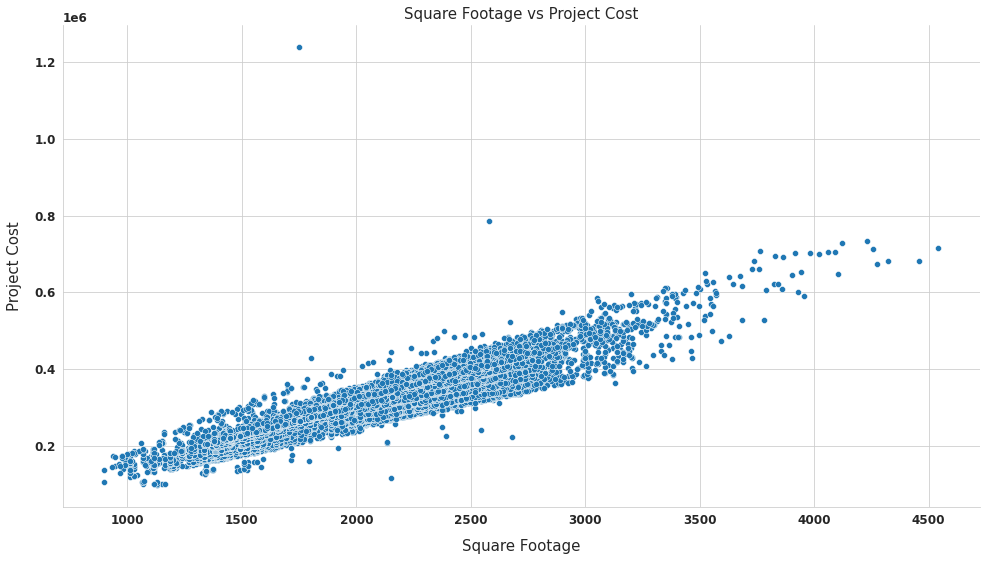

In [25]:
g = sns.relplot(x='Sqft', y='ProjectCost', data=df)
g.fig.set_size_inches(15,8)
plt.ylabel('Project Cost', fontsize= 15, labelpad = 12)
plt.xlabel('Square Footage', fontsize= 15, labelpad = 12)
plt.title('Square Footage vs Project Cost', fontsize=15);

There is a strong linear relationship between square footage and project cost. Visually, there are only appears to be a couple of outliers. For starters, I am going to remove the two values whose project costs appear greater than 780,000. After that I will remove the permit that is less than 200,000 in project cost but greater than 2,000 square feet.

In [26]:
#Concat the outliers together and then drop them from the dataframe using the drop_duplicates command

df1 = df.query('ProjectCost > 780000')
df2 = df.query('Sqft > 2000 & ProjectCost < 200000')
frames = [df1, df2]
outliers = pd.concat(frames)
df = pd.concat([df, outliers]).drop_duplicates(keep=False)

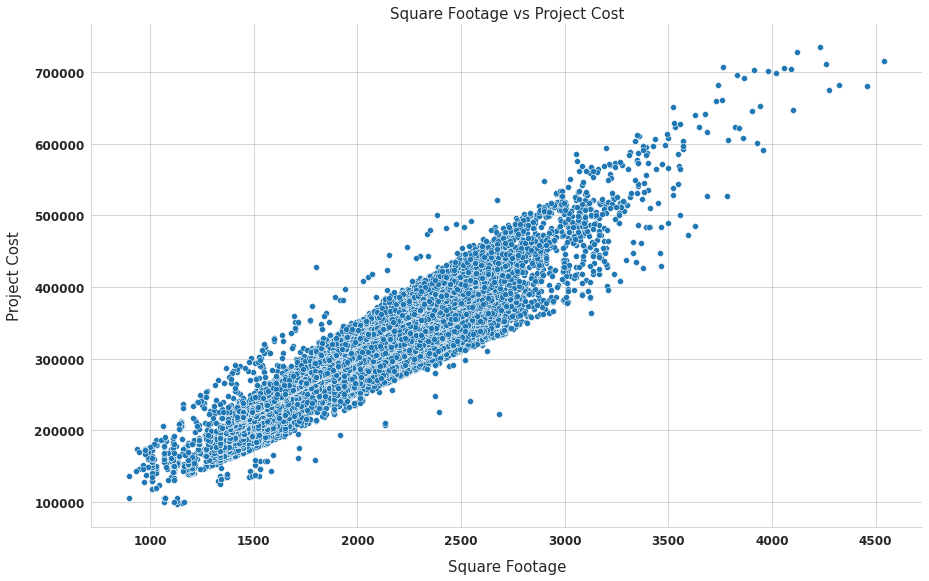

In [27]:
#Plot square footage vs project costs again

g = sns.relplot(x='Sqft', y='ProjectCost', data=df)
g.fig.set_size_inches(15,8)
plt.ylabel('Project Cost', fontsize= 15, labelpad = 12)
plt.xlabel('Square Footage', fontsize= 15, labelpad = 12)
plt.title('Square Footage vs Project Cost', fontsize= 15);

This looks much better. While there are some points that deviate from the trend, I am inclined to leave them in for now. My reason for this is that I would like to see how well my prediction model handles these values. Next, I would like to see how these variables are distributed.

Null hypothesis of normality is rejected.


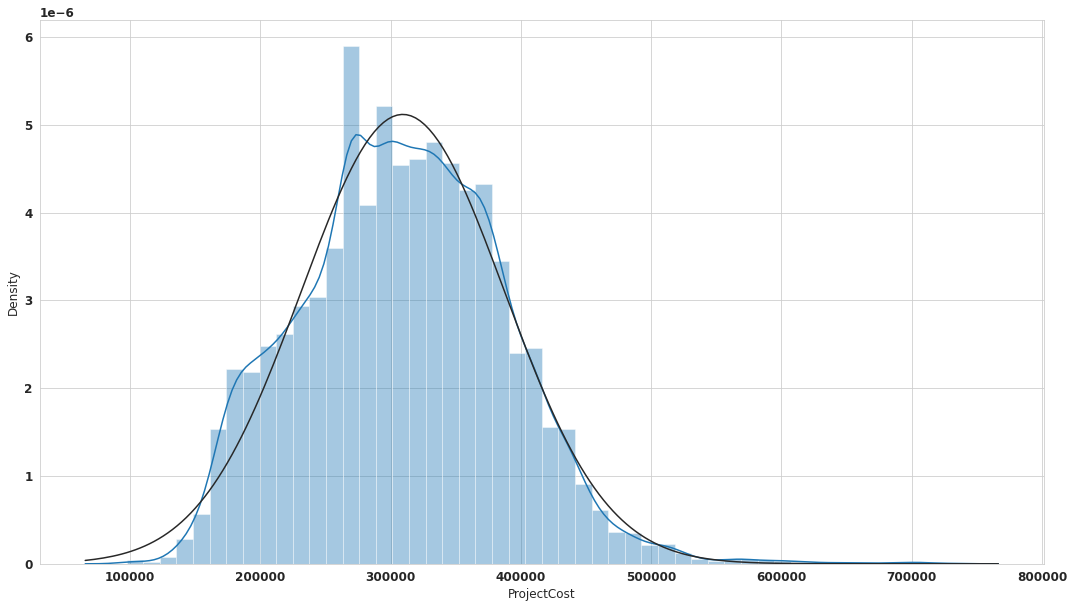

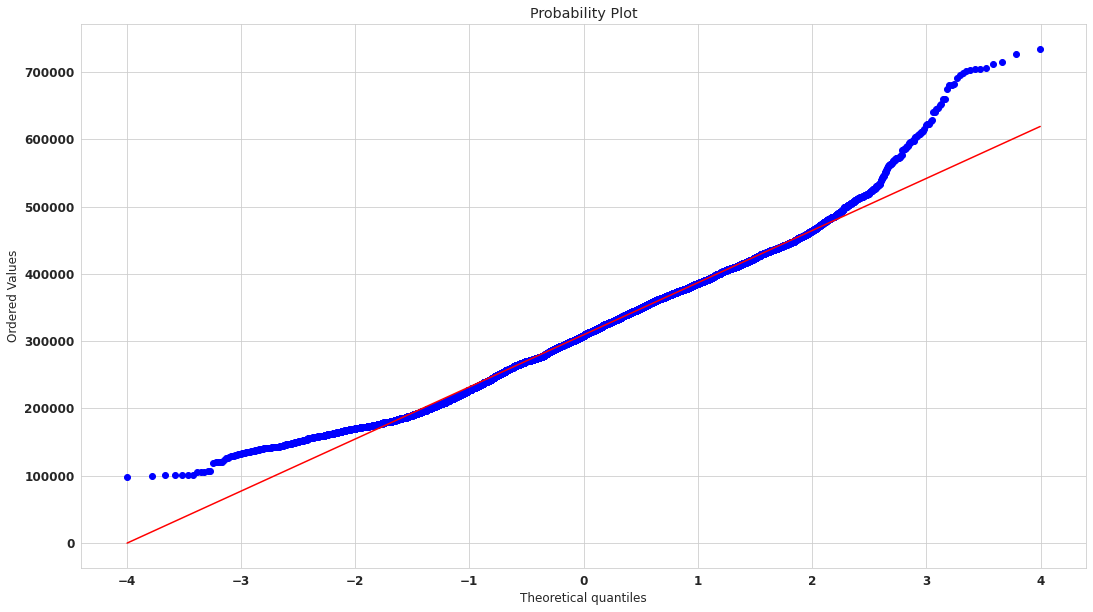

In [28]:
#Check the distribution for project costs.

fig = plt.subplots(figsize=[18,10])
sns.distplot(df['ProjectCost'], fit=norm)


fig = plt.figure(figsize=[18,10])
res = stats.probplot(df['ProjectCost'], plot=plt)

#Test for normality using Shapiro-Wilk test

shapiro_test = stats.shapiro(df['ProjectCost'])

if shapiro_test.pvalue <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


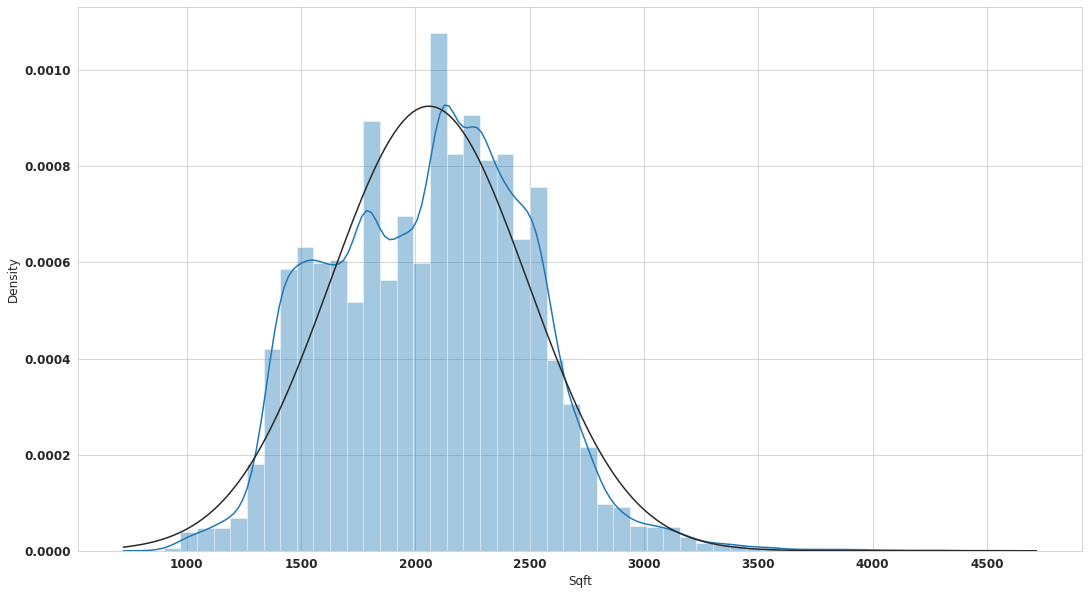

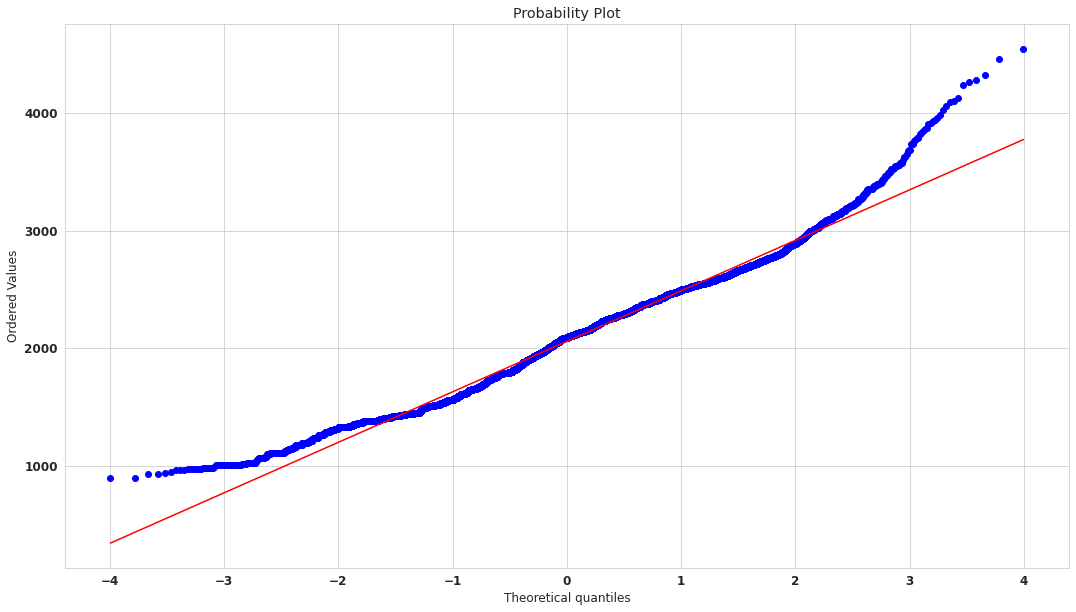

In [29]:
#Check the distribution for square footage.

fig = plt.subplots(figsize=[18,10])
sns.distplot(df['Sqft'], fit=norm)

fig = plt.subplots(figsize=[18,10])
res = stats.probplot(df['Sqft'], plot=plt)

#Test for normality using Shapiro-Wilk test

shapiro_test = stats.shapiro(df['Sqft'])

if shapiro_test.pvalue <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

I can see that both variables closely resemble a normal distribution but fail to meet the assumption of normality. I am inclined to leave the two variables like this for now and revisit them in the cost prediction model section.

This concludes the first part of the notebook. In the second part I will begin the exploratory data analysis.

## Exploratory Data Analysis

This portion of the notebook is going to look under the hood of the dataframe and hopefully uncover some insights. There are a lot of ways one can slice and dice the data. For starters, I want to visualize where the permits are located on a map. The City of Calgary provides a link to a community boundary map on its Open Data Portal. I will use this link to create a basemap of  the City of Calgary and then plot the permit data on top of it. Since the community map does not distinguish the four quadrants from each other I will color code the permits based on quadrant. Additionally, I would like to give some context to where the center of Calgary is. To do this I will create a point using the coordinates of Calgary City Hall, which is located in the downtown of Calgary.

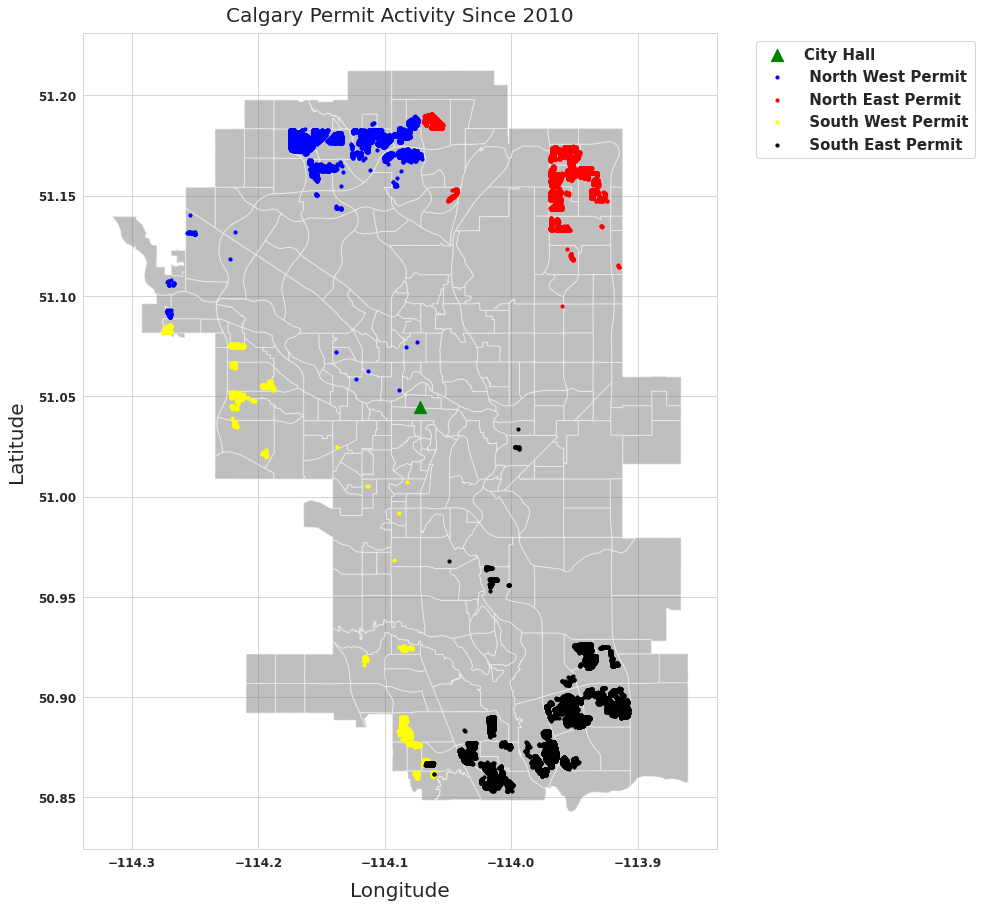

In [30]:
#Import geopandas
import geopandas as gpd

#Load in the community boundary map
url = 'https://data.calgary.ca/resource/surr-xmvs.geojson'
calgary = gpd.read_file(url)
CRS = "EPSG:4326"

#Create a geodataframe from the original dataframe using the points_from_xy command
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf.crs = CRS     #Set the geodataframe to the same coordinate reference system as the basemap

#Create seperate frames based on the quadrants
gdfNW = gdf[gdf.Quadrant == 'NORTH WEST']
gdfNE = gdf[gdf.Quadrant == 'NORTH EAST']
gdfSW = gdf[gdf.Quadrant == 'SOUTH WEST']
gdfSE = gdf[gdf.Quadrant == 'SOUTH EAST']

#Create a dataframe for the coordinates of City Hall

CH_lat_long = {'Latitude' : [51.0447], 'Longitude': [-114.0719]} 
CH = pd.DataFrame(CH_lat_long)

#Create a geodataframe from the City Hall dataframe
CHgdf = gpd.GeoDataFrame(CH, geometry=gpd.points_from_xy(CH.Longitude, CH.Latitude))
CHgdf.crs = CRS

#Overlay the frames on the Calgary map
base = calgary.plot(color='grey', alpha= 0.5, edgecolor='white', figsize=(18,15))
CHgdf.plot(ax = base, color= 'green', markersize= 150, marker= '^', label='City Hall')
gdfNW.plot(ax = base, color= 'blue', markersize= 10, label=' North West Permit')
gdfNE.plot(ax = base, color= 'red', markersize= 10, label=' North East Permit')
gdfSW.plot(ax = base, color= 'yellow', markersize= 10, label=' South West Permit')
gdfSE.plot(ax = base, color= 'black', markersize= 10, label=' South East Permit')

#Adjust title,  axis labels, and legend.
plt.title('Calgary Permit Activity Since 2010', fontsize=20, pad= 12)
plt.xlabel("Longitude", fontsize= 20, labelpad= 12)
plt.xticks(fontsize= 12)
plt.ylabel("Latitude", fontsize= 20, labelpad = 12)
plt.yticks(fontsize= 12)
plt.legend(prop={'size':15}, loc='upper left', bbox_to_anchor=(1.05, 1));

There are three takeaways from this map. The first is that Calgary is very much a sprawling city with the vast majority of single family permits being located in communities on the boundaries of the city. Only a handful of single family permits are located near the downtown area of Calgary. The second takeaway is that it appears the South East quadrant makes up the bulk of the single family permit activity since 2010. Lastly, some communities have only one, or very few, permits located in them. This could be a problem as it might lead to overfitting the prediction model.

Based on this, I would like to look at the permit breakdown by quadrant and then by community.

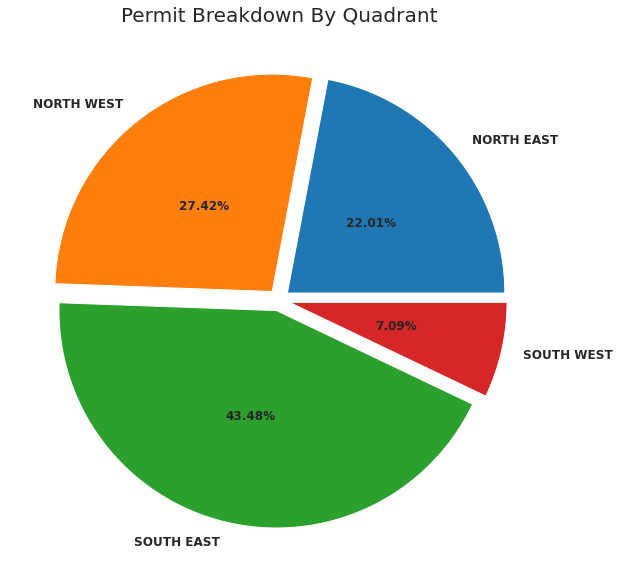

In [31]:
quadrant = df.groupby(df.Quadrant)['Units'].sum()
pie, ax = plt.subplots(figsize=[10,10])
labels = quadrant.keys()
plt.pie(x=quadrant, autopct="%.2f%%", explode=[0.05]*4, labels=labels, pctdistance=0.5)
plt.title("Permit Breakdown By Quadrant", fontsize=20);

The pie chart checks out with how the permit distribution appears on the map. The South East quadrant makes up the majority of the permit activity while the two northern quadrants make up decent proportions as well. Now I will have a look at how the permits are distributed across the individual communities.

In [32]:
values = df.Community.value_counts()
percent = df.Community.value_counts()/df.Community.count()*100
breakdown =pd.concat([values, percent], axis=1, keys=['Number of Permits', 'Percent of Total'])
breakdown['Cumulative Percentage'] = breakdown['Percent of Total'].cumsum()
breakdown

,Number of Permits,Percent of Total,Cumulative Percentage
AUBURN BAY,2019,9.41830,9.41830
CRANSTON,1731,8.07482,17.49312
EVANSTON,1490,6.95060,24.44372
NOLAN HILL,1287,6.00364,30.44736
MAHOGANY,1284,5.98964,36.43700
NEW BRIGHTON,1231,5.74241,42.17941
SKYVIEW RANCH,1014,4.73014,46.90955
SAGE HILL,1008,4.70215,51.61170
WALDEN,959,4.47357,56.08527
CORNERSTONE,913,4.25899,60.34426


This breakdown shows that there are quite a few communities with a low permit count. Additionally, the breakdown shows that the top 10 communities by permit count represent 60% of all the permits in the dataframe. With this in mind, I am thinking it doesn't make sense to use community as a feature in predicting project costs. The feature is sparse, and it is not practical to predict the cost of something that appears only once in the dataframe. Since communities can be consolidated into quadrants, I am going to opt for using this as a feature in the prediction model.

Next, I would like to get a sense of how the permits have been distributed by the quadrants over time.

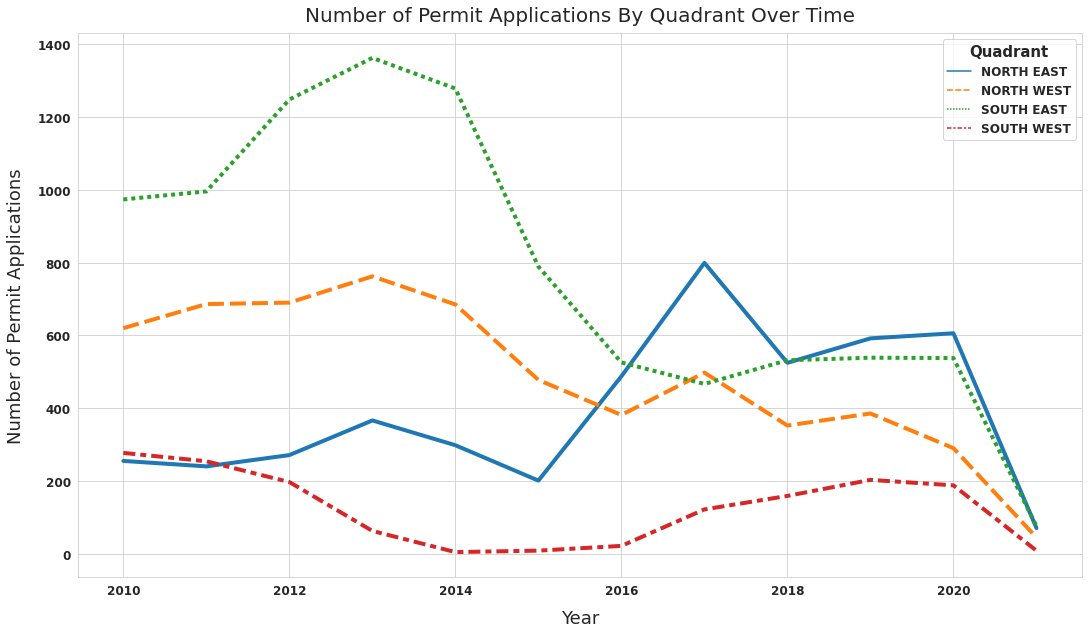

In [33]:
#Create a column that represents the applied year
df['AppliedYear'] = pd.DatetimeIndex(df['AppliedDate']).year

#Group the permits by applied year and quadrant
permits_by_quadrant = df[['AppliedYear', 'Quadrant', 'Units']].copy()
permits_by_quadrant = permits_by_quadrant.groupby(['Quadrant',pd.Grouper(key='AppliedYear')]).sum()

#Plot the results of the grouper
fig, ax = plt.subplots(figsize=[18,10])
sns.lineplot(data=permits_by_quadrant, x="AppliedYear", y="Units", hue="Quadrant", style="Quadrant", lw =4)
plt.setp(ax.get_legend().get_texts(), fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='15')
plt.xlabel("Year", fontsize= 18, labelpad =12)
plt.ylabel("Number of Permit Applications", fontsize= 18, labelpad =12)
plt.title("Number of Permit Applications By Quadrant Over Time", fontsize=20, pad= 12);

As of 2016 the North East has been the favoured quadrant among the top 10 builders. At the time of working on this notebook (August 2021) very few homes have been built this year. This explains why there is a drastic drop in the number of permits at the end of the graph. However, the general trend line for number of permits applied for each year appears downward as of 2014.

Now I would like to look at how the costs per square foot compare by quadrant.

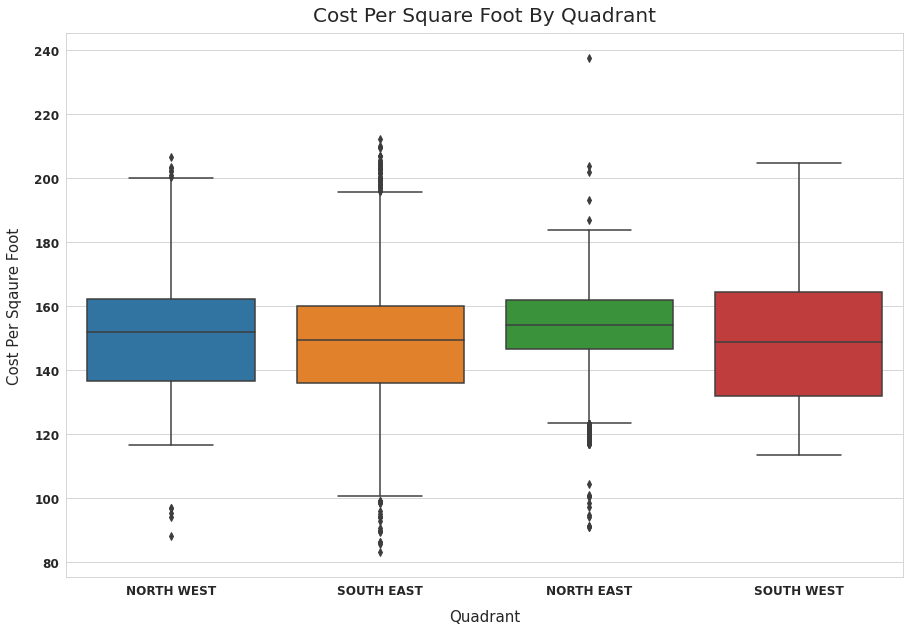

In [34]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Quadrant', y= 'CostPerSqft', data=df)
plt.xlabel("Quadrant", fontsize= 15, labelpad =12)
plt.ylabel("Cost Per Sqaure Foot", fontsize= 15, labelpad =12)
plt.title("Cost Per Square Foot By Quadrant", fontsize=20, pad= 12);

All of the quadrants have similar median values around $150. Excluding outliers, it appears that the North East quadrant has a much tighter cost per square foot spread in comparison to the other quadrants. I would like to get a sense for how the costs per square foot has changed over time. To do this I will plot the average cost per square foot by quadrant over time.

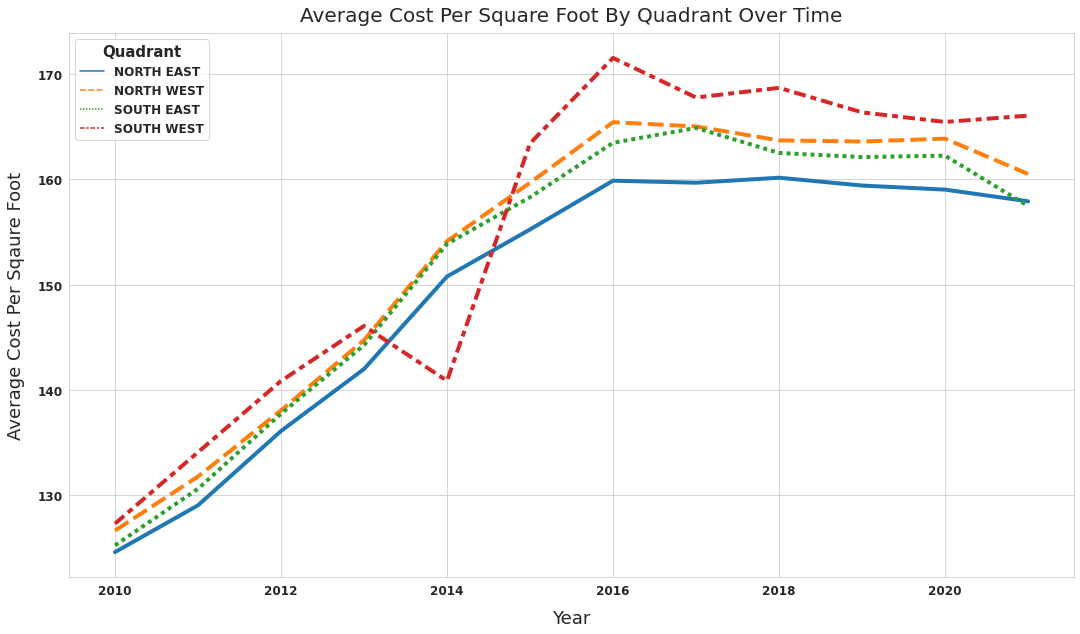

In [35]:
#Group by quadrant and applied years and take the mean of the cost per square foot

cost_by_quadrant = df[['AppliedYear', 'Quadrant', 'CostPerSqft']].copy()
cost_by_quadrant = cost_by_quadrant.groupby(['Quadrant',pd.Grouper(key='AppliedYear')]).mean()

#Plot the results 

fig, ax = plt.subplots(figsize=[18,10])
sns.lineplot(data=cost_by_quadrant, x="AppliedYear", y="CostPerSqft", hue="Quadrant", style="Quadrant", lw =4)
plt.setp(ax.get_legend().get_texts(), fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='15')
plt.xlabel("Year", fontsize= 18, labelpad =12)
plt.ylabel("Average Cost Per Sqaure Foot", fontsize= 18, labelpad =12)
plt.title("Average Cost Per Square Foot By Quadrant Over Time", fontsize=20, pad = 12);

Interestingly, the average cost per square foot increased across all of the quadrants from the period between 2010 and 2016. From 2016 onward the average cost per square foot plateaued, and as of this year appears to be heading downwards. There doesn't appear to be much deviation in terms of the order as well. For example, the North East has maintained the lowest average cost per sqaure foot for basically the entire dataframe. This is with the exception of 2014 when the South West quadrant had a drastic drop in the average cost per sqaure foot. However, this drop could be explained by the fact that in 2014 the South West qaudrant had very few permit applications that year.

Considering that the North East has the smallest average cost per square foot, this might explain why it has been the most favoured qaudrant as seen by the permit breakdown over time chart.

For the next couple of cells, I would like to take a look at the builders and see how they compare to each other. I will start this off with a bar chart showing the number of permits each builder has completed.

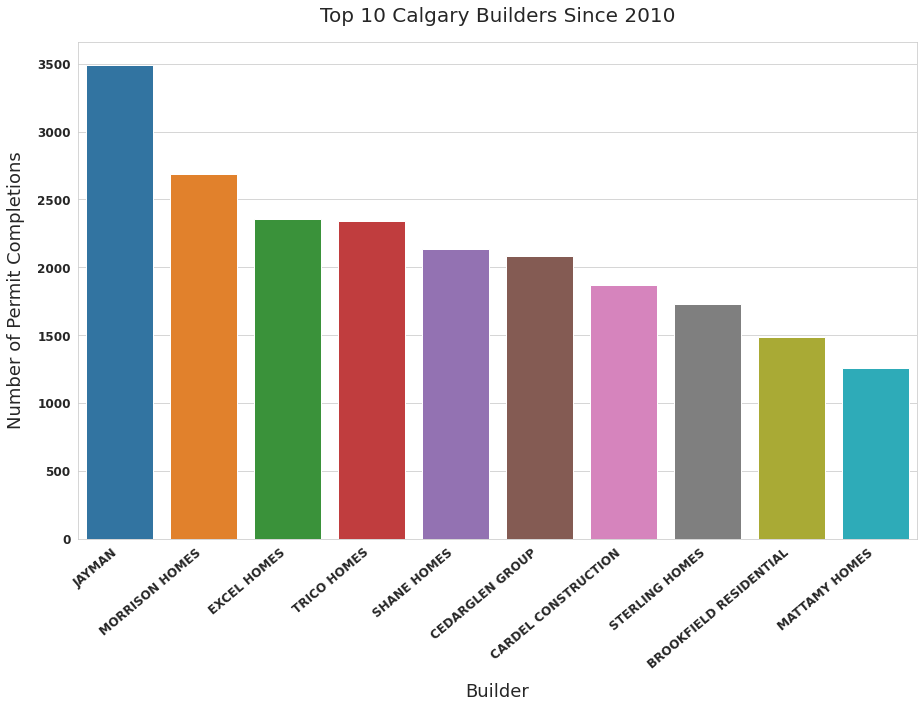

In [36]:
plt.figure(figsize=(13,10))
ax = sns.countplot(x= 'Builder', order= df.Builder.value_counts().index, data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Top 10 Calgary Builders Since 2010', fontsize=20, pad= 20)
plt.xlabel("Builder", fontsize= 18, labelpad =12)
plt.ylabel("Number of Permit Completions", fontsize= 18, labelpad = 12)
plt.tight_layout()

All of the builders are in excess of a thousand completed single family permits since 2010. The lion's share goes to Jayman with nearly 3,500 homes being built in this timeframe.

Next, I would like to see how the applications are distributed by builders over time.

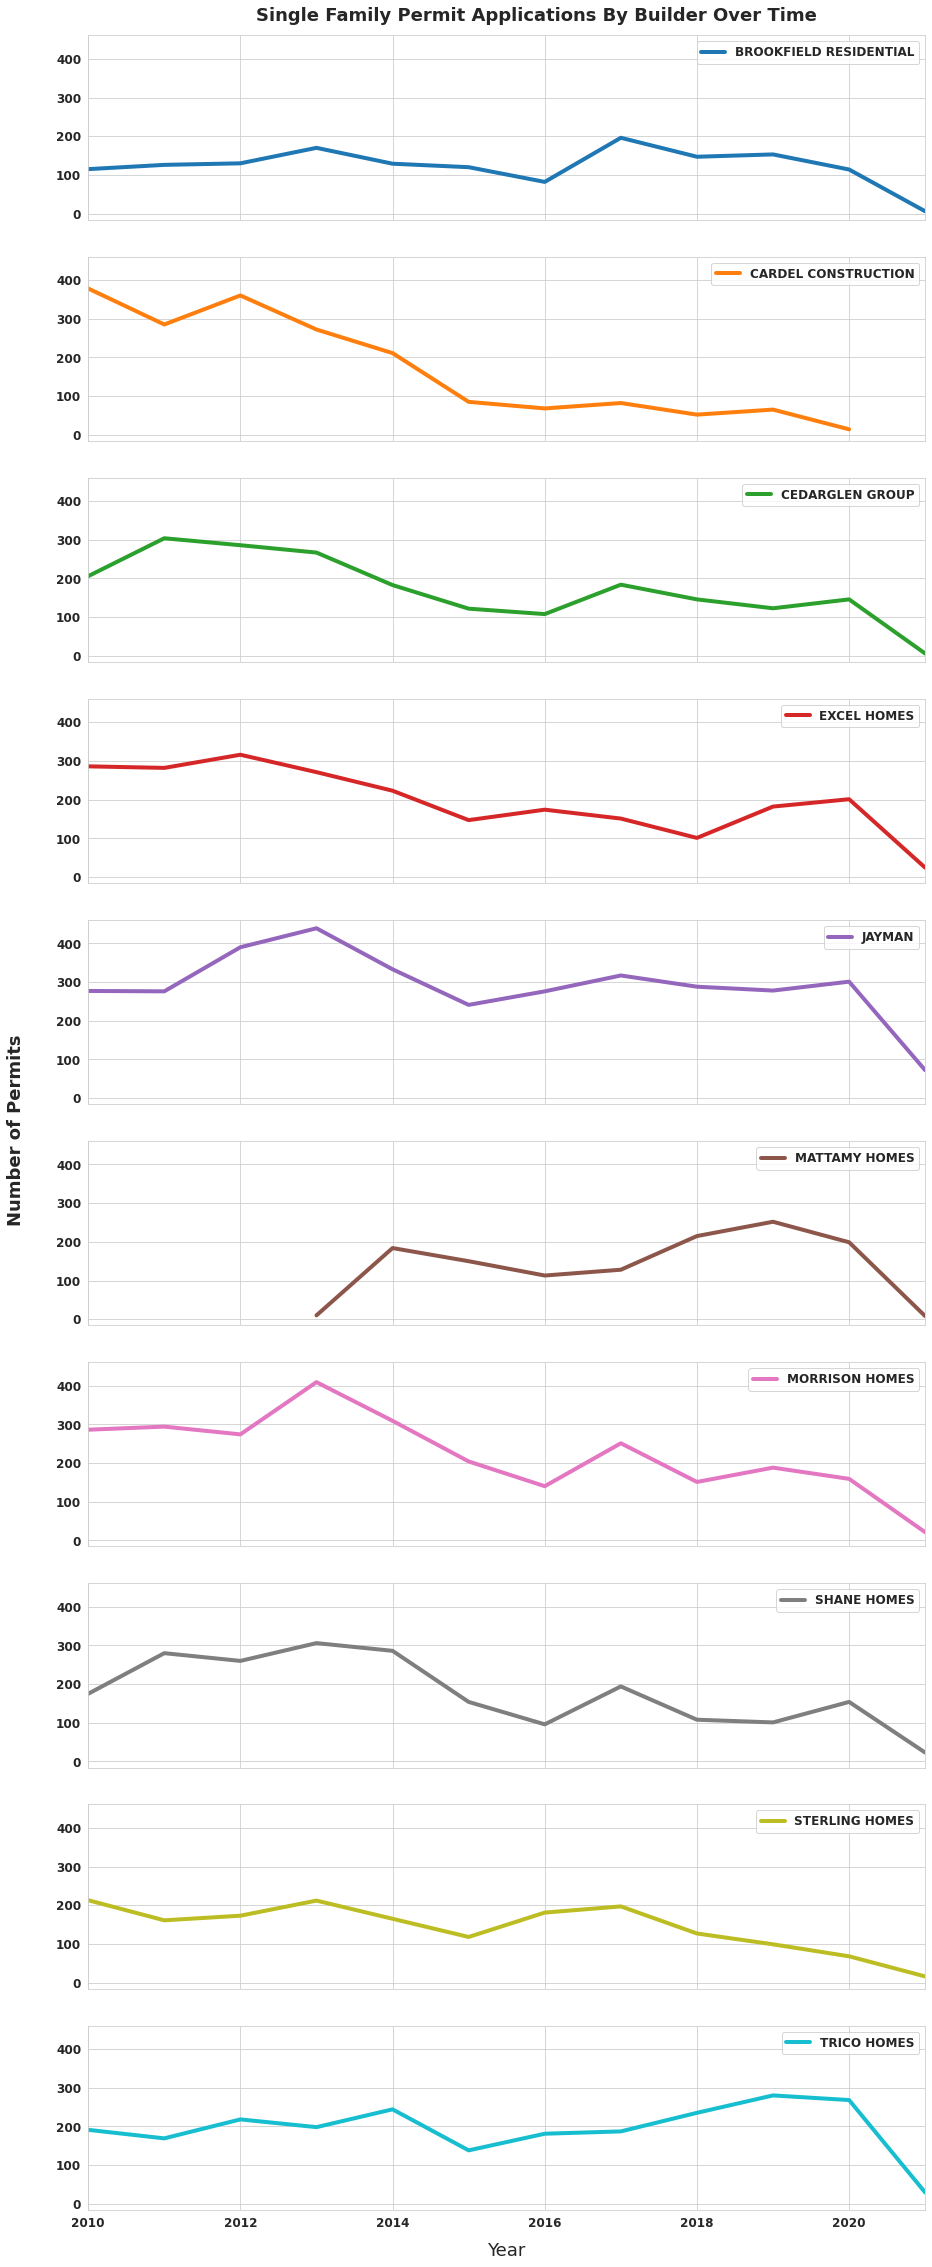

In [37]:
#Create a pivot table that aggregates the number of permits by builder. Use NaN to represent missing data so it is not plotted.

permits_by_builder = df[['AppliedDate', 'Builder', 'Units']].copy()
permits_by_builder = permits_by_builder.pivot_table(index = 'AppliedDate', columns = 'Builder', values = 'Units', 
                                                    aggfunc= 'sum', fill_value = 0)
permits_by_builder = permits_by_builder.resample('Y').sum().replace(0,np.NaN) #Resample to go from monthly data to a yearly sum

#Plot the results using subplot
fig, ax = plt.subplots(figsize=(15, 40))
permits_by_builder.plot(ax=ax, subplots= True, sharex= True, sharey= True, lw = 4) 
plt.xlabel("Year", fontsize= 18, labelpad =12)

#Add labels to the plot - I found this makes the title and y-axis look better
fig.text(0.05, 0.5,'Number of Permits', va= 'center', rotation = 'vertical', fontsize=18)
fig.text(0.28, 0.885,'Single Family Permit Applications By Builder Over Time', fontsize=18);

From the subplot it appears that all of the builders have either maintained or decreased the number of permit applications per year since 2010. The most dramatic change is Cardel, which shows a strong downward trend in their permit applications as of 2010. In fact, at the time of writing this, they have not completed a single permit for this year while all of the other builders have. There is no clear uptrend for any of the builders. It is worth noting that Mattamy did not enter the Calgary market until 2013 which is explained by their plot starting that year.

Now I will have a look into the project cost distribution by builder.

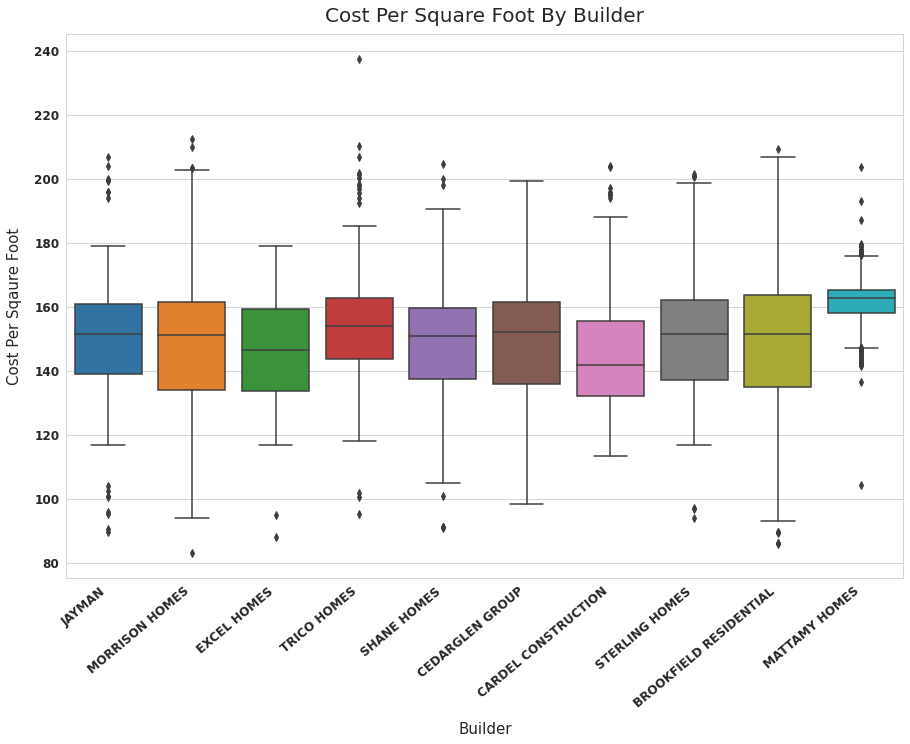

In [38]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Builder', y= 'CostPerSqft', order= df.Builder.value_counts().index, data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel("Builder", fontsize= 15, labelpad =12)
plt.ylabel("Cost Per Sqaure Foot", fontsize= 15, labelpad =12)
plt.title("Cost Per Square Foot By Builder", fontsize=20, pad= 12);

The median construction cost per square foot is fairly consistent across the builders. They all appear to be around the \\$150 value, with the exception of Mattamy whose median value is above $160. 

In terms of the spread, Morrison and Brookfield appear to have fairly large construction cost spreads ranging from \\$90 per square foot to above \\$200 per square foot. Mattamy on the other hand has a much tighter spread in comparison to the rest of the builders but with several outliers.

Similar to what I did in the quadrant portion, I will now have a look at how the average cost per square foot has changed over time by the builder. For starters, I want to visualize all of the builders in one graph to see if the general trend line amongst the builders shares the same pattern as the quadrants.

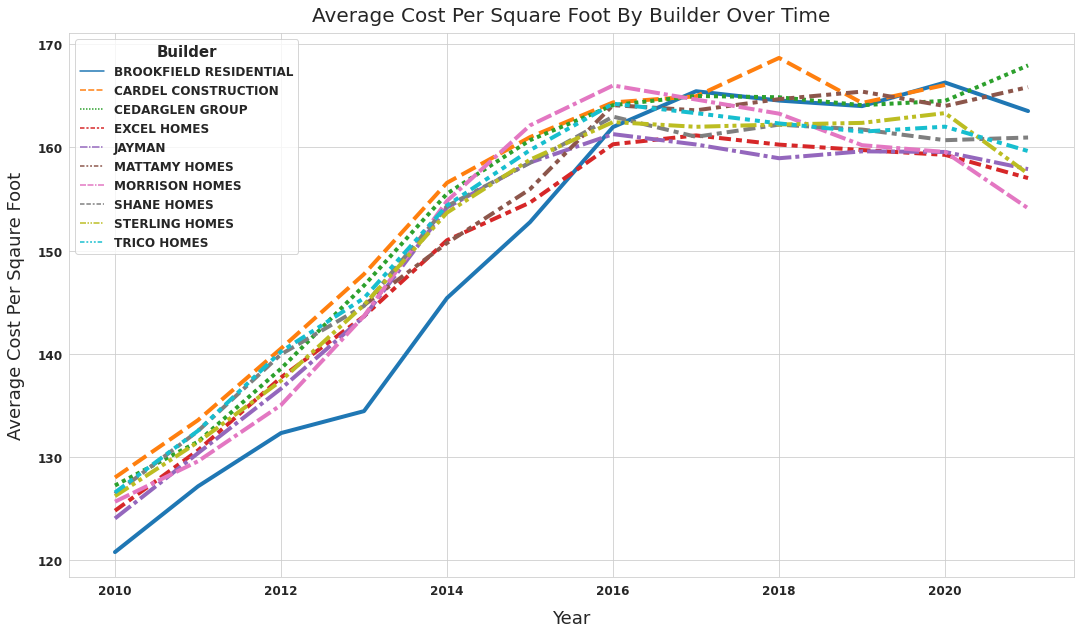

In [39]:
#Group the builders using grouper and take the mean of cost per square foot

cost_by_builder = df[['AppliedYear', 'Builder', 'CostPerSqft']].copy()
cost_by_builder = cost_by_builder.groupby(['Builder',pd.Grouper(key='AppliedYear')]).mean()

#Plot the results of the grouper 

fig, ax = plt.subplots(figsize=[18,10])
sns.lineplot(data=cost_by_builder, x="AppliedYear", y="CostPerSqft", hue="Builder", style="Builder", lw =4)
plt.setp(ax.get_legend().get_texts(), fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='15')
plt.xlabel("Year", fontsize= 18, labelpad =12)
plt.ylabel("Average Cost Per Sqaure Foot", fontsize= 18, labelpad =12)
plt.title("Average Cost Per Square Foot By Builder Over Time", fontsize=20, pad = 12);

This is the same trend that was observed in the average cost per square foot by quadrant. There is strong upward trend in the average cost per square foot that plateaus as of 2016. All of the builders appear to share this trend. Similar to the quadrant chart, it appears that some of the builders are starting to reduce their average cost per square foot as of this year.

To get a sense for this, I will subplot the same data to look at the builders individually.

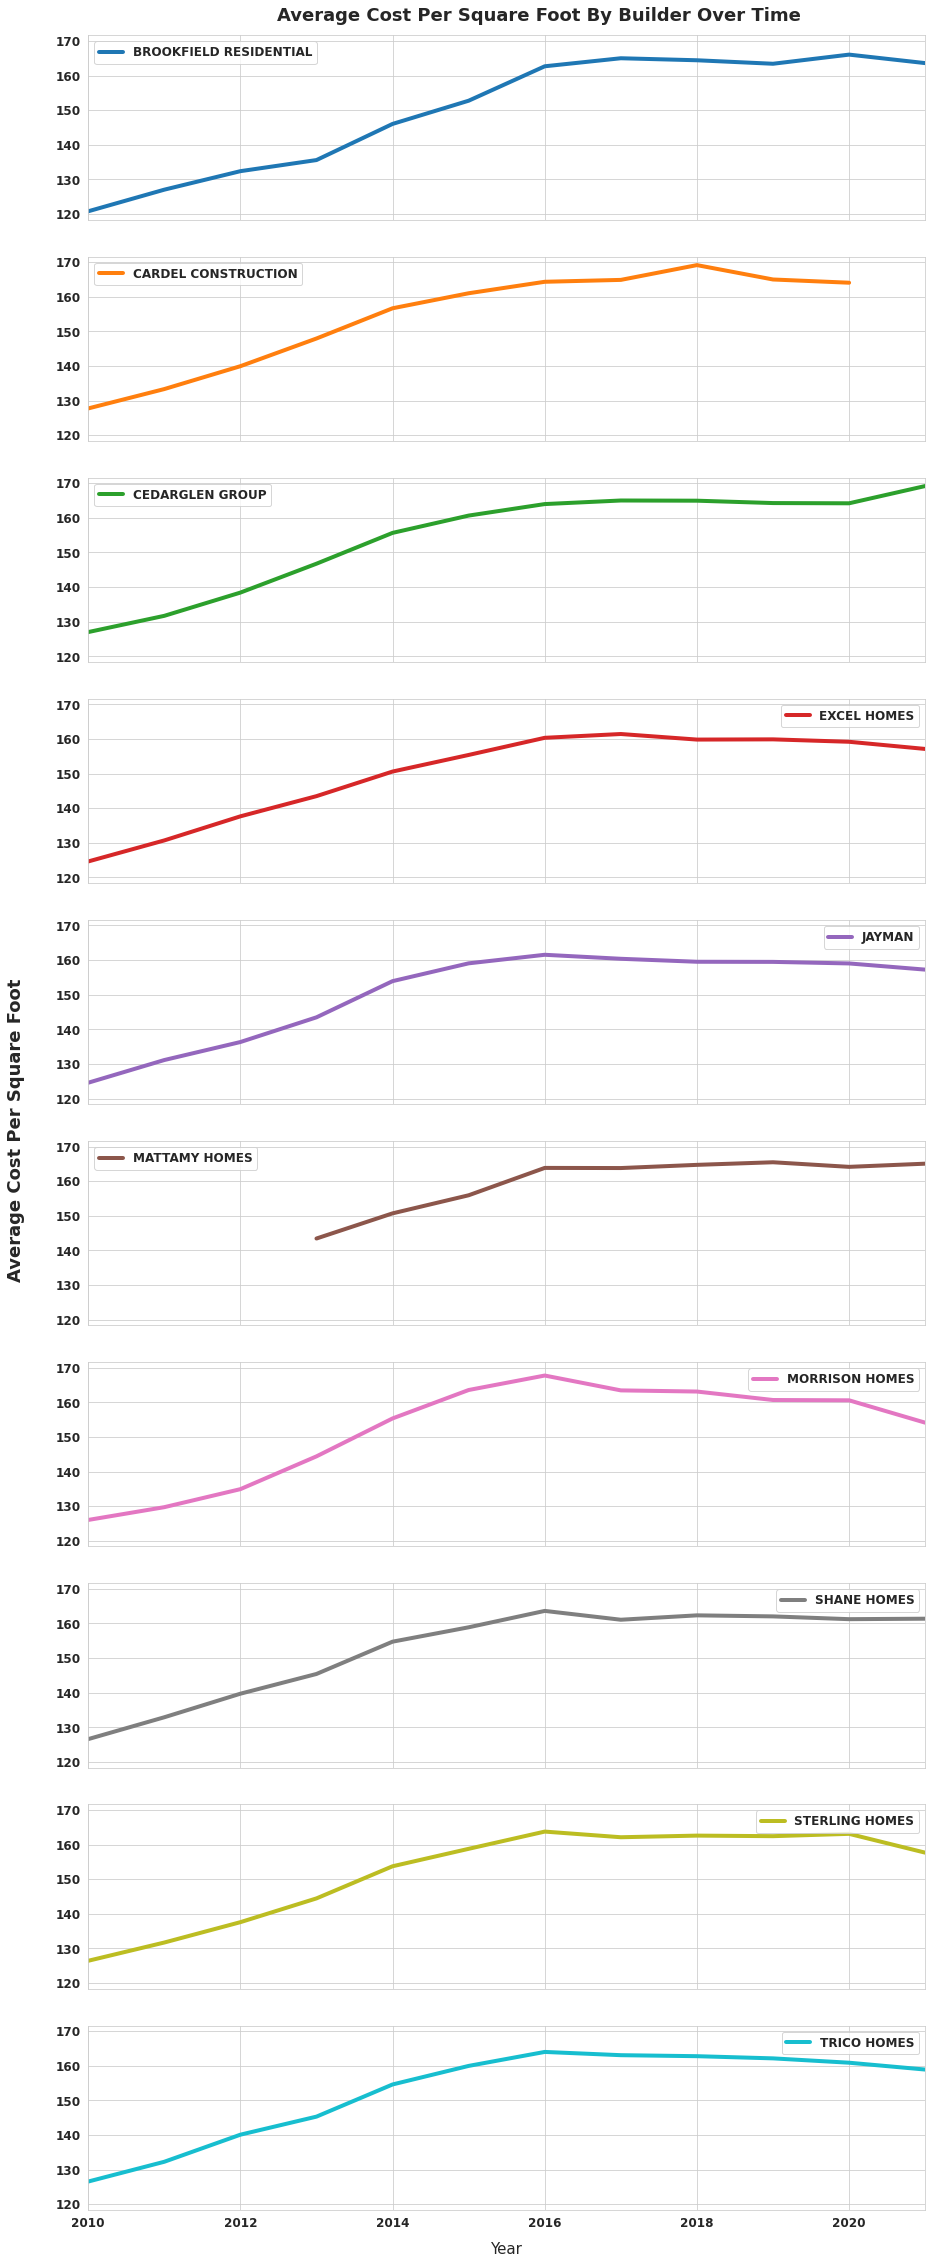

In [40]:
cost_by_builder = df[['AppliedDate', 'Builder', 'CostPerSqft']].copy()
cost_by_builder = cost_by_builder.pivot_table(index = 'AppliedDate', columns = 'Builder', values = 'CostPerSqft', 
                                              aggfunc= np.mean, fill_value = 0).replace(0,np.NaN)
cost_by_builder = cost_by_builder.resample('Y').mean()

#Plot the results using subplot
fig, ax = plt.subplots(figsize=(15, 40))
cost_by_builder.plot(ax=ax, subplots= True, sharex= True, sharey= True, lw = 4)
plt.xlabel("Year", fontsize= 15, labelpad =12)

#Add figure test for y-axis and title
fig.text(0.05, 0.5,'Average Cost Per Square Foot', va= 'center', rotation = 'vertical', fontsize=18)
fig.text(0.3, 0.885,'Average Cost Per Square Foot By Builder Over Time', fontsize=18);

With the exception of Cedarglen, Shane Homes, and Mattamy, all of the builders are showing a reduction in their average cost per square foot as of this year. I think it is too early to say whether this trend is indicative of something. The reason for this is that these builders have only completed a handful of permits at the time of writing this notebook. It would be interesting to see if this trend continues as the builders complete more homes this year.

For the next couple of cells, I want to look at some complementary figures. While these won't necessarily be features in my prediction model, I am going to take a look into them to see if I can uncover some insights. I am going to start by looking into the construction duration.

In [41]:
df.ConstructionDuration.describe()

count   21,437.00000
mean       185.76461
std        124.16019
min         46.00000
25%        135.00000
50%        163.00000
75%        196.00000
max      2,191.00000
Name: ConstructionDuration, dtype: float64

A few things stand out to me here. A mean value of 185 days seems reasonable, assuming 30 days in a month, this makes for roughly six months to complete a house once the permit has been issued. However, a minimum construction duration of 46 days and a maximum construction duration of 2,191 days does not seem reasonable. To get a better sense I will plot square footage and construction duration on a scatter plot. In theory, there should be a positive linear relationship between the two, with an increase in square footage showing an increase in construction duration.

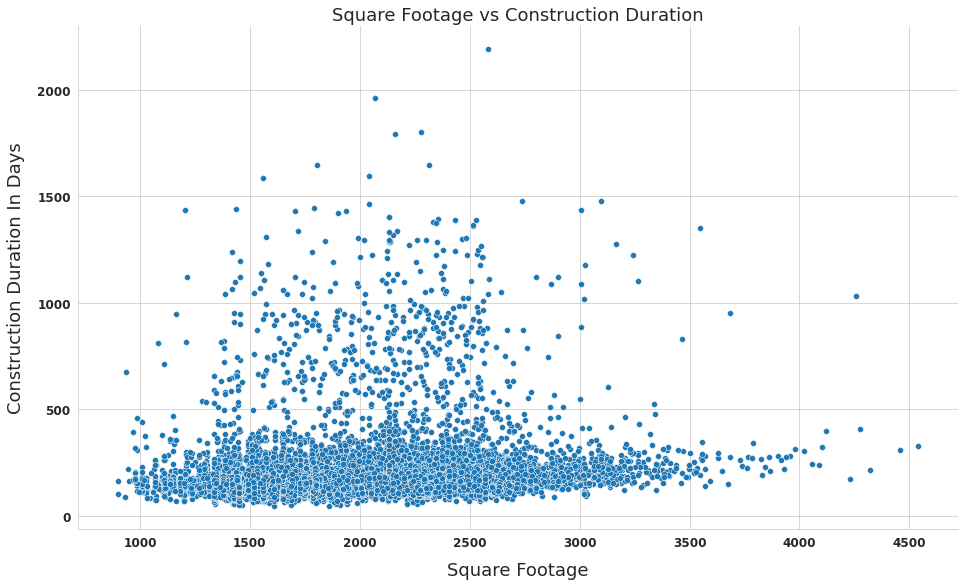

In [42]:
g = sns.relplot(x='Sqft', y='ConstructionDuration', data=df)
g.fig.set_size_inches(15,8)
plt.ylabel('Construction Duration In Days', fontsize= 18, labelpad = 12)
plt.xlabel('Square Footage', fontsize= 18, labelpad = 12)
plt.title('Square Footage vs Construction Duration', fontsize= 18);

It appears that there is no relationship between these two variables, and that a large portion of permits are well in excess of the 185 day average. After seeing this plot, I think that the duration between when a permit is issued and when a permit is completed is not an accurate representation of construction duration.

A builder is unlikely to start the construction of a house if it has not been sold to a buyer, especially in a downward market. What I think is happening here is that the builders are getting the permits sorted out in advance of a home being sold. This way the builder can begin the construction of the house without delay and with the insurance that the house has already been sold to a buyer.

While I cannot sufficiently analyze construction duration, I do think I am able to look at the seasonality of when permits are completed. I believe the builders have to provide the city with a fee/bond that gets returned to the builder upon the house being completed. Therefore, it is in the builder’s best interest to notify the city that a house has been completed. I also know that the houses under construction are subject to building code inspections which are updated in the original dataframe.

With this in mind, I would like to plot the seasonality of when permits are completed. I will start with a bar chart that shows a snapshot for the months across the entire dataframe.

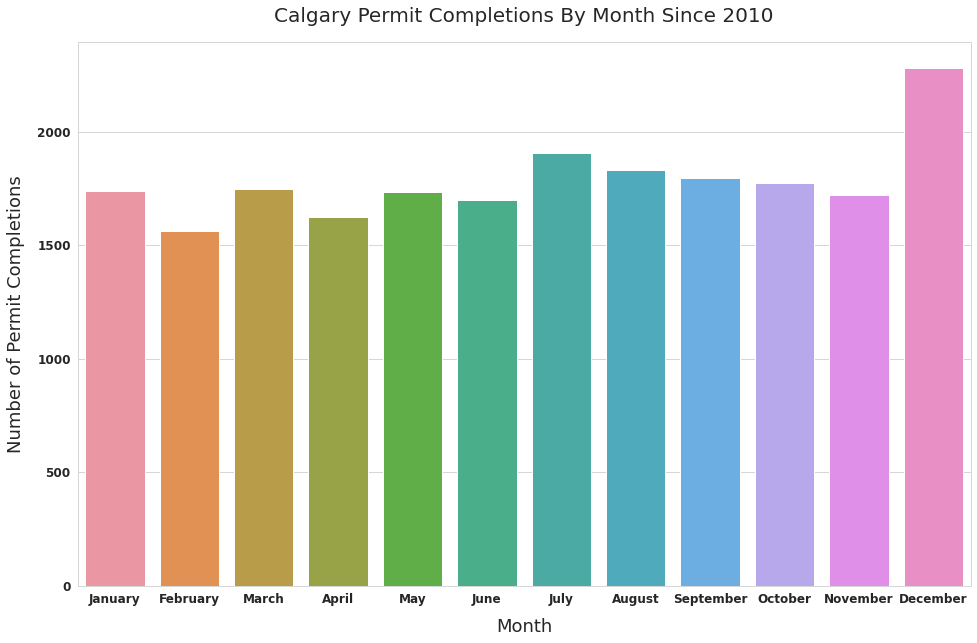

In [43]:
#Create a column that represents the month a permit was completed

df['CompletedMonth'] = pd.DatetimeIndex(df['CompletedDate']).month_name()

#Plot the months using countplot
plt.figure(figsize=(16,10))
sns.countplot(x= 'CompletedMonth', order = ['January','February','March','April','May','June','July', 'August',
                                           'September', 'October', 'November', 'December'], data=df)

plt.title('Calgary Permit Completions By Month Since 2010', fontsize=20, pad= 20)
plt.xlabel("Month", fontsize= 18, labelpad =12)
plt.ylabel("Number of Permit Completions", fontsize= 18, labelpad = 12);

It seems logical that December would have the largest number of housing completions. Not only is it the fiscal year end for many companies, but it is also the point in the year where the building conditions become unfavourable due to the weather. Assuming that a single family house in Calgary takes an average of six months to build, this means that the construction typically begins in the summer months of June/July when the weather is more favourable.

To get a sense of seasonality, I will plot each year on a line plot to see how they compare to each other.

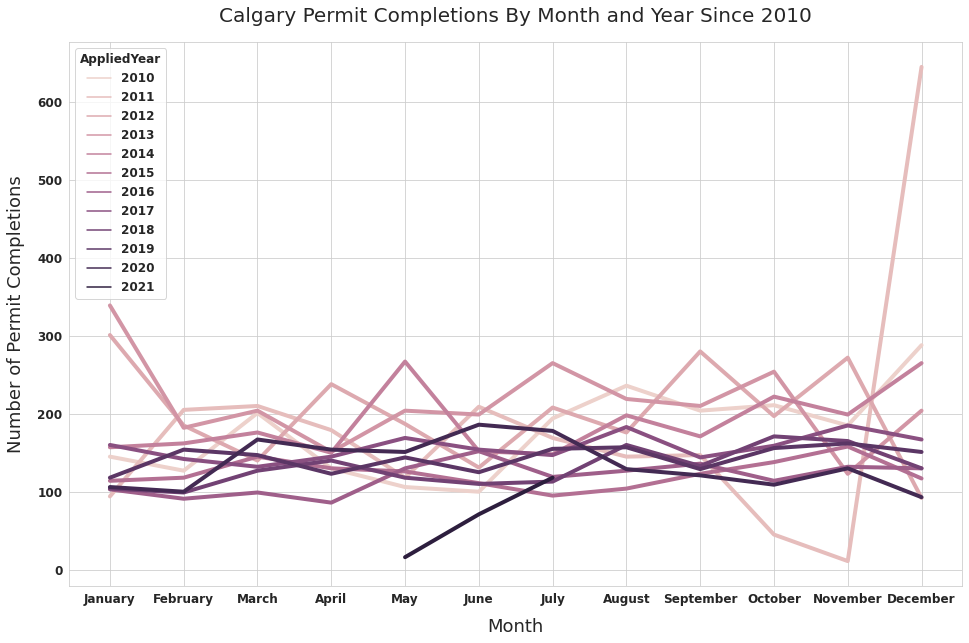

In [44]:
#Group the number of permits completed by year and month

permit_completions_by_month = df[['AppliedYear', 'CompletedMonth', 'Units']].copy()
permit_completions_by_month = permit_completions_by_month.groupby(['AppliedYear',pd.Grouper(key='CompletedMonth')]).sum()
permit_completions_by_month = permit_completions_by_month.reindex(level = 1, labels = calendar.month_name)

#Plot the results of the grouper

fig, ax = plt.subplots(figsize=[16,10])
sns.lineplot(data=permit_completions_by_month, x="CompletedMonth", y="Units", lw =4, hue='AppliedYear', legend= 'full')

plt.title('Calgary Permit Completions By Month and Year Since 2010', fontsize=20, pad= 20)
plt.xlabel("Month", fontsize= 18, labelpad =12)
plt.ylabel("Number of Permit Completions", fontsize= 18, labelpad = 12);

While there is a lot happening in this line chart, it is apparent that in one year the builders completed far more permits in the month of December than any other year. I am not sure why this is the matter? Perhaps a new legislation was introduced that year making residential building less feasible in future years? Regardless, it does shed light on the previous bar chart which showed a significant bump of permit completions taking place in the month of December. I also noticed that in one year no permits were completed between the months of January through April. 

After looking at this line chart it doesn't appear that there is any clear seasonality as to when permits are completed. It is not reasonable to say that most permits are completed in the month of December since one event has skewed the data making it appear this way.

This concludes the second portion of this notebook. My key takeaways from this section are:

- The South East quadrant has been the overall most favoured quadrant amongst the builders as of 2010. However, as of 2016 the North East quadrant has surpassed the South East in the number of annual permit applications.


- The North East quadrant has a smaller cost per square foot range compared to the other quadrants. This quadrant has also shown to have the lowest average cost per square foot over time as well.


- The average cost per square foot increased year over year from 2010 to 2016. From 2016 to 2020 the average cost per square foot plateaued, and starting in 2021 it appears that the average cost per square foot is going down. This was observed in all of the quadrants and for most of the builders.


- No builder has an upward trend in the number of annual permit applications. In fact, there is a downward trend in the number of annual permit applications.


- It is not reasonable to assume that construction duration is the period between when a permit is issued and when a permit is deemed complete. Without knowing the actual construction start date it is not practical to analyse the construction duration.


- There does not appear to be any clear seasonality as to when permits are completed. While the month of December may appear to be the most favoured, this is the result of an outlier event that has greatly increased the number of permit completions for that month.

In the last portion of this notebook, I will build a cost prediction model to predict the project cost of a given permit.

## Cost Prediction Model

To start the cost prediction model, I am going to create a new data frame with the model features. The features I am going to use to predict the project cost are applied year, builder, quadrant, square footage, latitude, and longitude. As previously mentioned, the community feature is quite sparse and can naturally be consolidated into quadrants. Using quadrants will also create natural clusters for the latitude and longitude features, which will help the model performance.

In [45]:
model = df[['AppliedYear', 'Builder','Quadrant', 'Sqft', 'Latitude', 'Longitude', 'ProjectCost']].copy()
model.head()

,AppliedYear,Builder,Quadrant,Sqft,Latitude,Longitude,ProjectCost
17,2019,TRICO HOMES,NORTH WEST,"2,501.00000",51.17866,-114.08431,"404,123.15000"
27,2018,MORRISON HOMES,SOUTH EAST,"2,999.00000",50.85353,-114.01558,"519,244.25000"
31,2018,BROOKFIELD RESIDENTIAL,SOUTH EAST,"1,781.00000",50.86927,-113.95864,"269,800.59000"
45,2018,MORRISON HOMES,SOUTH EAST,"1,525.00000",50.86616,-114.06158,"248,422.27000"
48,2018,JAYMAN,SOUTH EAST,"1,522.00000",50.86616,-114.06615,"241,374.10000"


I have already seen that there is a strong correlation between square footage and project cost, and a small correlation between application year and project cost. However, I will still check for multicollinearity with the other features.

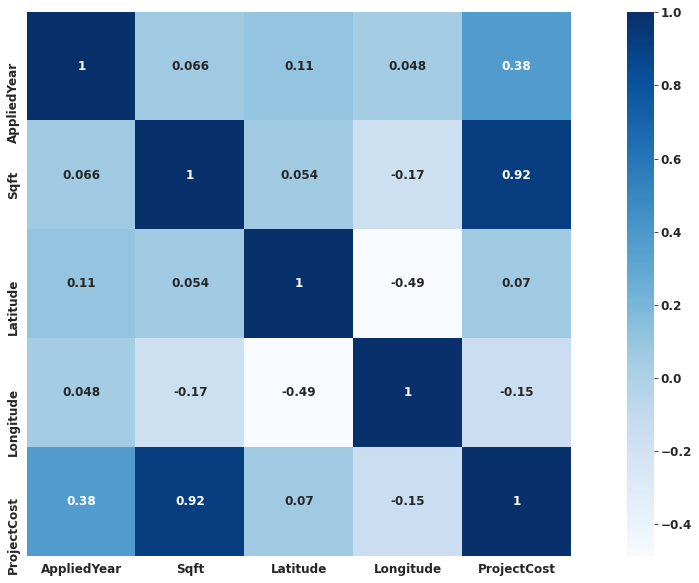

In [46]:
#Plot correlation using heatmap
corrmat = model.corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, square=True, cmap = 'Blues', annot = True);

There does not appear to be any multicollinearity and not surprisingly latitude and longitude have no correlation with project cost. Next, I will one hot encode the categorical variables and then establish my X and y variables. I will note that the model performance increased when dropping the first categorical column.

In [47]:
#One hot encode categorical variables.

model = pd.get_dummies(model, drop_first = True)
model.head()

,AppliedYear,Sqft,Latitude,Longitude,ProjectCost,Builder_CARDEL CONSTRUCTION,Builder_CEDARGLEN GROUP,Builder_EXCEL HOMES,Builder_JAYMAN,Builder_MATTAMY HOMES,Builder_MORRISON HOMES,Builder_SHANE HOMES,Builder_STERLING HOMES,Builder_TRICO HOMES,Quadrant_NORTH WEST,Quadrant_SOUTH EAST,Quadrant_SOUTH WEST
17,2019,"2,501.00000",51.17866,-114.08431,"404,123.15000",0,0,0,0,0,0,0,0,1,1,0,0
27,2018,"2,999.00000",50.85353,-114.01558,"519,244.25000",0,0,0,0,0,1,0,0,0,0,1,0
31,2018,"1,781.00000",50.86927,-113.95864,"269,800.59000",0,0,0,0,0,0,0,0,0,0,1,0
45,2018,"1,525.00000",50.86616,-114.06158,"248,422.27000",0,0,0,0,0,1,0,0,0,0,1,0
48,2018,"1,522.00000",50.86616,-114.06615,"241,374.10000",0,0,0,1,0,0,0,0,0,0,1,0


In [48]:
#Establish x and y variables

y = model.ProjectCost
X = model.drop(['ProjectCost'], axis =1)

Since latitude and longitude do not have linear effects on project cost, I am going to build my cost prediction model using a tree-based regression model that does not require normalization or scaling. There are three models that I would like to compare; decision tree, random forest, and gradient boosting.

For the decision tree and random forest models, I am going to leave the model parameters as the default to see how they perform. In theory, the gradient boosting model should perform better than both of these models, however, this model is a little more nuanced in terms of its parameters. Therefore, I am going to do some hyperparameter tuning on this model to come up with the best performing parameters and then see how the model compares to the other two.

To compare the model performance to each other I am going to look at the mean absolute error, mean squared error, root mean squared error, and R2 scores. In short, I want to see the mean absolute error, mean squared error, and root mean squared error scores as low as possible while having a high R2 score.

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Create a function that prints out the valuation metrics

def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('Mean Absolute Error:', mae)
    print('Mean Sqaured Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
#Establish the train and test sets with test size of 30%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

## Decision Tree

In [50]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state = 1)
dtr.fit(X_train, y_train)
preds = dtr.predict(X_test)

print_evaluate(y_test, preds)

Mean Absolute Error: 8855.39078358209
Mean Sqaured Error: 232991400.58751765
Root Mean Squared Error: 15264.055836753141
R2 Square 0.9613182090495798
__________________________________


The decision tree model holds up well and has delivered good scores across all of the performance metrics. If I was to predict the project cost of a house based on the decision tree, I would expect my prediction to be within \\$8,855 of the true value. Considering the average project cost of a single family house in Calgary is around \\$310,000 this is pretty good. Next up is the random forest.

## Random Forest

In [51]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(random_state = 1)
forest_model.fit(X_train, y_train)
preds = forest_model.predict(X_test)

print_evaluate(y_test, preds)

Mean Absolute Error: 7433.150401927862
Mean Sqaured Error: 144511396.9396837
Root Mean Squared Error: 12021.289321020591
R2 Square 0.9760078713966341
__________________________________


Not surprisingly, the random forest model performs better than the decision tree. This is due to the fact that this algorithm is an aggregation of many decision trees that produce an average score. Compared to the decision tree, it has lowered the mean absolute error, mean squared error, root mean squared error and increased the R2 score. Finally, I will look at the gradient boosting model.

## Hyperparameter Tuning The Gradient Boosting Model

Due to computational limitations, I am opting to use the RandomizedSearchCV module over GridSearchCV, to find out which hyperparameters produce the best performing gradient boosting model. Specificly, I will use five-fold cross-validation through 10 iterations in which a set of random hyperparameters are tested.

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
rs = RandomizedSearchCV(gbr, {
    'loss': ['ls','lad','huber'],
    'n_estimators': [100, 200, 300, 500, 1000],
    'learning_rate': [0.05, 0.1, 0.15],
    'min_samples_split': [2, 4, 6]
    }, 
    cv = 5,
    return_train_score = False,
    n_iter = 10,
    random_state = 1)

rs.fit(X_train, y_train)
rs.best_params_

{'n_estimators': 500,
 'min_samples_split': 4,
 'loss': 'ls',
 'learning_rate': 0.1}

Based on the random search, the above cell shows which are the best performing parameters for the gradient boosting model. Next, I will create a new gradient boosting model, pass these parameters to it, and see how it performs.

In [53]:
#Use **kwargs for passing in the best parameters

gbr = GradientBoostingRegressor(**rs.best_params_, random_state = 1)
gbr.fit(X_train, y_train)
preds = gbr.predict(X_test)
print_evaluate(y_test, preds)

Mean Absolute Error: 7736.332548967241
Mean Sqaured Error: 138153821.0670287
Root Mean Squared Error: 11753.8853604682
R2 Square 0.9770633713860645
__________________________________


The gradient boosting model has scored better than the random forest model in terms of mean squared error, root mean squared error, and R2 score. The random forest model marginally edged the gradient boosting model in the mean absolute error score though. All things considered, this appears to be the best performing model with the lowest root mean squared error and highest R2 score.

Using this model I can expect my predictions, on average, to be within \$7,736 of the true value.

At this point I would like to predict the project cost of a completely new single family house where I provide the variables.

## Predicting The Project Cost Of A New House

I would like to predict the project cost of a 2,750 square foot house in the South East quadrant that was completed this year. Since Jayman is the largest builder by value count, I think it is fitting to predict what their project costs would be.

In [54]:
#Provide the features you want to value. Provide them in the exact same arrangement as the training set.

house_to_value = [
    2021, #Applied Year
    2750, #Sqft
    51.15566, #Latitude
    -113.93072, #longitude
    0, #Cardel
    0, #Cedarglen
    0, #Excel Homes
    1, #Jayman
    0, #Mattamy
    0, #Morrison
    0, #Shane
    0, #Sterling
    0, #Trico
    0, #North West
    1, #South East
    0, #SouthWest
]

#Need to pass the value of the house as an array
homes_to_value = [house_to_value]

#Run the model and make a prediction for the house in the array
predicted_home_values = gbr.predict(homes_to_value)

#Return the prediction of the one house
predicted_value = predicted_home_values[0]

print("This house has an estimated project cost of ${:,.2f}".format(predicted_value))

This house has an estimated project cost of $451,642.30


Based on the variables that I have provided, the gradient boosting algorithm has produced the above value.

This concludes my notebook. Thank you for taking the time to read this, I hope you found it insightful.